In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from matplotlib import pyplot as plt

from statsmodels.tsa.stattools import kpss, adfuller
from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [3]:
def plot_ts_acf(df, x, y, n_lags=range(1,26)):
    _, _, = plt.subplots(figsize=(12,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1));

    sns.lineplot(df, x=x, y=y, color='k', marker='o', ax=ax0)
    plot_acf(df[y].dropna(), lags=n_lags, ax=ax1)
    plot_pacf(df[y].dropna(), lags=n_lags, ax=ax2)

    ax0.set_title('Seasonal Difference')

    for axi in [ax0, ax1, ax2]: axi.grid('on')

    plt.tight_layout();

def plot_ts_resid(df, x, y, n_lags=range(1,10), title=''):
    _, _, = plt.subplots(figsize=(12,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1));

    ax0.plot(df[y], marker='o', color='k',)
    #ax0.hlines(0, 2000, df['Resid'].shape[0], color='k', linestyle='--')

    plot_acf(df[y], ax=ax1, lags=n_lags)

    ax2.hist(df[y], bins=len(df) // 4)

    ax0.set_title(title)
    for axi in [ax0, ax1, ax2]: axi.grid('on')

    plt.tight_layout();

### 1.0. Stationary Concept

Enquanto Exponential Smoothing são baseados em descrever a tendência e a sazonalidade e podemos utilizar o gráfico da decomposição para escolher um ETS adequado que irá fitar os dados, já modelos arima descrever as correlações nos dados e utilizamos gráficos como acf e pacf para selecionar um modelo arima adequado, entretanto, modelos arima possuem uma hipótese que os dados são estacionários!

#### 1.1. Stationary Time Series

Se $y_t$ é estacionário, os valores de "$s$" não dependem do tempo $t$, é uma propriedade que a série não depende em qual nível é observada, a distribuição de probabilidade é "igual" ou bem semelhante ao longo do tempo $t$. Portanto, séries com tendência e sazonalidade não são estacionárias pois ambos os fatores alteram o valor da série em diferentes $t$'s.

No livro existe essa imagem que ilustra as séries.

![image](https://otexts.com/fpp3/fpp_files/figure-html/stationary-1.png)

- a) Não é estacionária pois possui tendência, a variação da média e da variância não são constantes ao longo de $t$.
- b) A série b é estacionária, apesar de ter alguns picos (são apenas 3, então não caracteriza como heteroskedasticity, série isso se a variação aumentasse ao longo do nível) ela não possui tendência e sazonalidade.
- c) Não é estacionária pois a variação em diferentes níveis é diferente.
- d) Não é estacionária pois existe uma sazonalidade mínima que é possível observar e também a variação é diferente ao longo do tempo, meio que difícil de observar também.
- e) Não é estacionária pois existe tendência.
- f) Não é estacionária pois existe tendência.
- g) É estacionária pois como são dados anuais e eles não possuem sazonalidade, pois um ano não volta no tempo, e sim ciclos que não são sazonalidade.
- h) Não é estacionária pois possui sazonalidade, diferente da g), esses dados são em quarters.
- i) Não é estacionária pois possui tendência, sazonalidade e a variação da série não é constante ao longo do nível (heteroskedasticity).

Então podemos definir que séries estacionárias são:

1. Horizontais (Sem tendência).
2. Variação constante (Homoscedasticity).
3. Sem sazonalidade.

Para identificarmos se a série é estacionária, geralmente utilizamos gráficos acf e pacf e o próprio time plot e alguns testes chamados unit roots.

Mas, como que é são as transformações de uma série não estacionária em uma série estacionária, esse é o novo objetivo!

Na figura acima, a série a) é a mesma que a série b), entretanto a série b) foi transformada utilizando uma técnica chamada diferenciação.

Vamos entrar em detalhes nesses temas todos.

#### 1.2. ACF, Time Plots e Unit Roots

Para identificar se a série é estacionária ou não, usamos duas técnicas, a visualização e testes de hipóteses.

Utilizando a visualização podemos olhar o time plot e os gráficos de ACF.

Para séries estacionárias, o gráfico de ACF chega em 0 bem rapidamente, caso a série não seja estacionária, ela vai apresentar sazonalidade no ACF e decair até zero em lags bem grandes.

In [126]:
df = pd.read_csv("../data/gafa_stock.csv", index_col=[0])
df["Date"] = pd.to_datetime(df["Date"])

df = df[(df["Symbol"] == "GOOG") & (df["Date"].dt.year == 2018)].reset_index(drop=True)

Exemplo de uma série não estacionária.

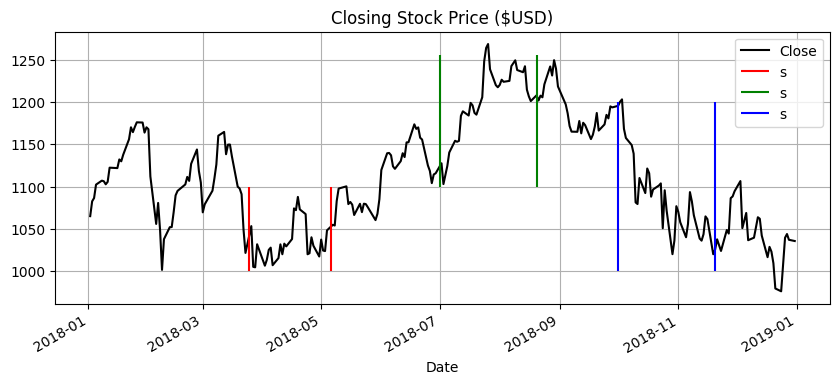

In [43]:
ax = df.plot(
    x="Date", y="Close",
    grid=2, figsize=(10, 4), color="k",
    title="Closing Stock Price ($USD)"
);

ax.vlines(x="2018-05-06", ymin=1000, ymax=1100, color="r")
ax.vlines(x="2018-03-25", ymin=1000, ymax=1100, color="r", label="s")
ax.vlines(x="2018-07-01", ymin=1100, ymax=1255, color="g")
ax.vlines(x="2018-08-20", ymin=1100, ymax=1255, color="g", label="s")
ax.vlines(x="2018-10-01", ymin=1000, ymax=1200, color="b")
ax.vlines(x="2018-11-20", ymin=1000, ymax=1200, color="b", label="s");

ax.legend();

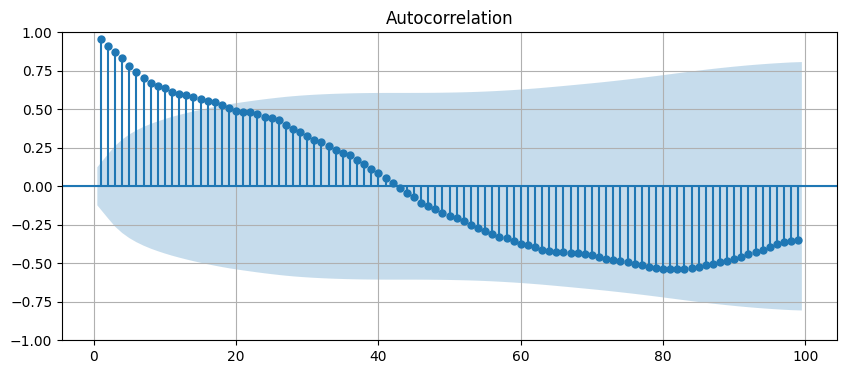

In [48]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["Close"], lags=range(1, 100), ax=ax);
ax.grid(2);

Aplicando a diferenciação, temos uma série estacionária.

1. A diferenciação ajuda a estabilizar a média.
2. A série "diferenciada" nada mais é que a diferença: $y_{t}' = y_{t} - y_{t-1}$.
3. Não é possível calcular a diferença do primeiro valor da série.

Podemos aplicar a diferenciação da Diferenciação também e assim vai, mas na prática acabamos não utilizando mais que uma diferenciação.

Existe também a diferenciação sazonal $y_{t}' = y_t - y_{t-m}$ onde $m$ é a ordem da sazonalidade (12 para dados mensais, 4 para quarters)...

In [66]:
df["DiffClose"] = df["Close"].diff()
df["DiffDiffClose"] = df["Close"].diff().dropna().diff().dropna()

In [70]:
3.92 - 17.47

-13.549999999999999

In [67]:
df.head()

,Symbol,Date,Open,High,Low,Close,Adj_Close,Volume,DiffClose,DiffDiffClose
0,GOOG,2018-01-02,1048.339966,1066.939941,1045.229980,1065.000000,1065.000000,1237600.0,NaN,NaN
1,GOOG,2018-01-03,1064.310059,1086.290039,1063.209961,1082.479980,1082.479980,1430200.0,17.479980,NaN
2,GOOG,2018-01-04,1088.000000,1093.569946,1084.001953,1086.400024,1086.400024,1004600.0,3.920044,-13.559936
3,GOOG,2018-01-05,1094.000000,1104.250000,1092.000000,1102.229980,1102.229980,1279100.0,15.829956,11.909912
4,GOOG,2018-01-08,1102.229980,1111.270020,1101.619995,1106.939941,1106.939941,1047600.0,4.709961,-11.119995


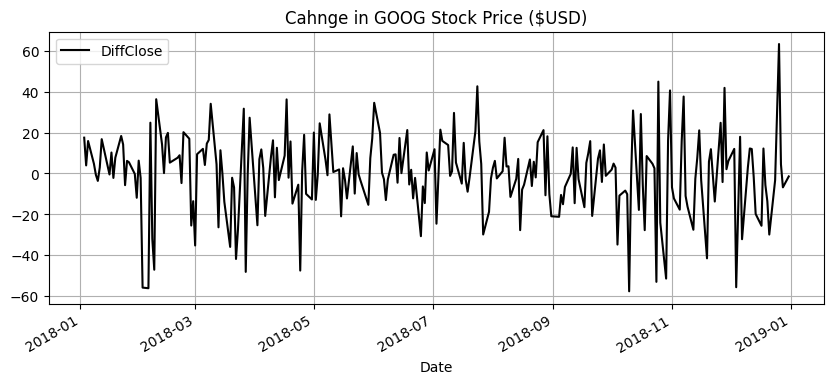

In [59]:
ax = df.plot(
    x="Date", y="DiffClose",
    grid=2, figsize=(10, 4), color="k",
    title="Cahnge in GOOG Stock Price ($USD)"
);

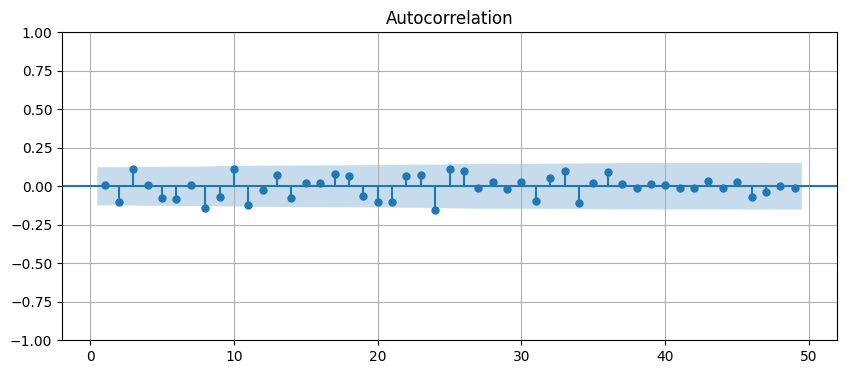

In [64]:
fig, ax = plt.subplots(figsize=(10, 4))
plot_acf(df["DiffClose"].dropna(), lags=range(1, 50), ax=ax);
ax.grid(2);

No livro é citado mais algumas preparações nos dados a fim de obter a diferenciação, por exemplo utilizando o Log e a diferenciação, primeiro se estabiliza a variância e após isso aplica-se a diferenciação sazonal de 12.

Entretanto estão faltando alguns meses iniciais para a diferenciação sazonal!

Irei filtrar esses meses também e verificar como que a diferenciação sazonal se comporta se eu eventualmente reorganizar os dados.

In [100]:
df  = pd.read_csv("../data/PBS.csv", index_col=[0])
df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

df = df.loc[df.ATC2 == "A10", ["Month", "Cost"]].groupby("Month").sum() / 1e6

In [109]:
df.head(3)

,Cost
Month,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221


In [110]:
index = pd.date_range(start="1991-01-01", end=df.index.max(), freq="MS")

index[~index.isin(df.index)]

DatetimeIndex(['1991-01-01', '1991-02-01', '1991-03-01', '1991-04-01',
               '1991-05-01', '1991-06-01'],
              dtype='datetime64[ns]', freq='MS')

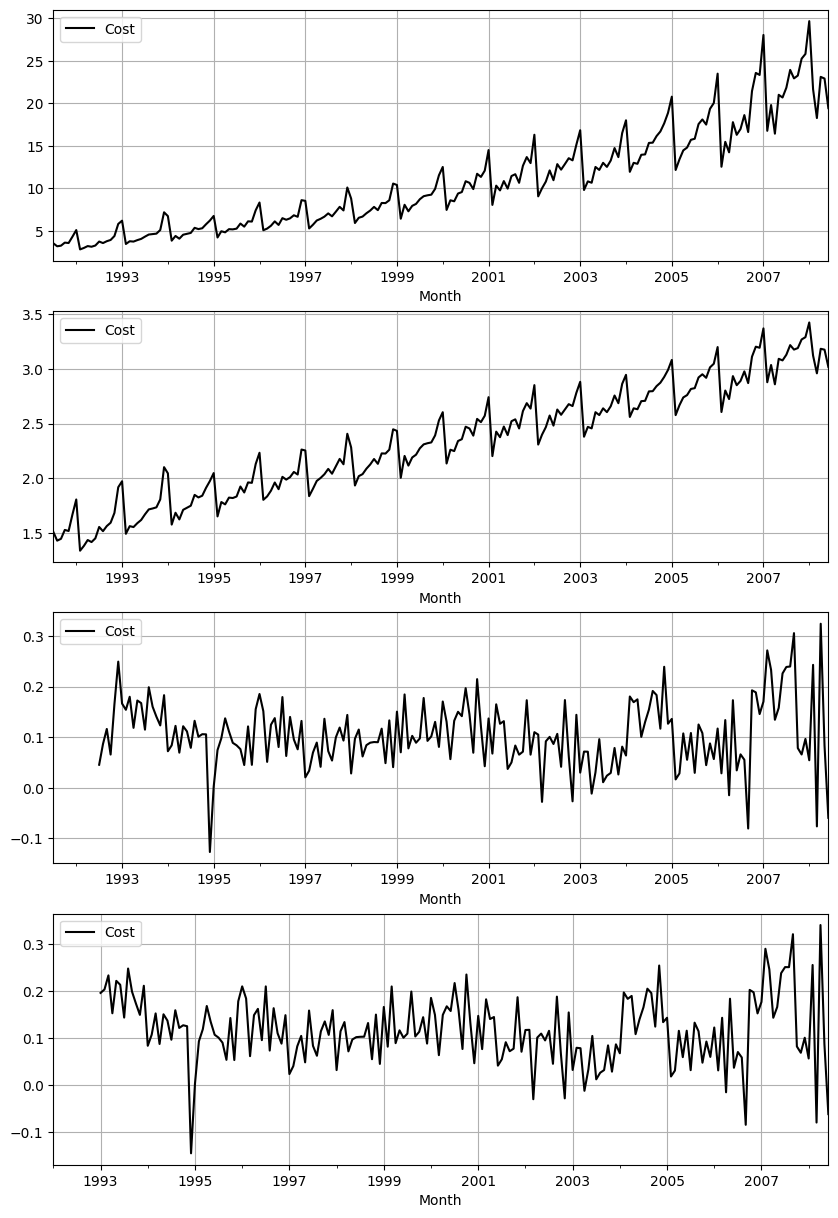

In [119]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))

df.plot(ax=ax[0], color="k")
np.log1p(df).plot(ax=ax[1], color="k")
np.log1p(df).diff(periods=12).plot(ax=ax[2], color="k")
np.log(df[df.index.year > 1991]).diff(12).plot(ax=ax[3], color="k")

for axi in ax: axi.grid(2)

In [120]:
df  = pd.read_csv("../data/PBS.csv", index_col=[0])
df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

df = df.loc[df.ATC2 == "H02", ["Month", "Cost"]].groupby("Month").sum() / 1e6

A diferenciação seasonal é apropriada a ser feito primeiro, após isso a diferenciação de periodo = 1, pois pode conter sazonalidade mesmo com a diferenciação = 1.

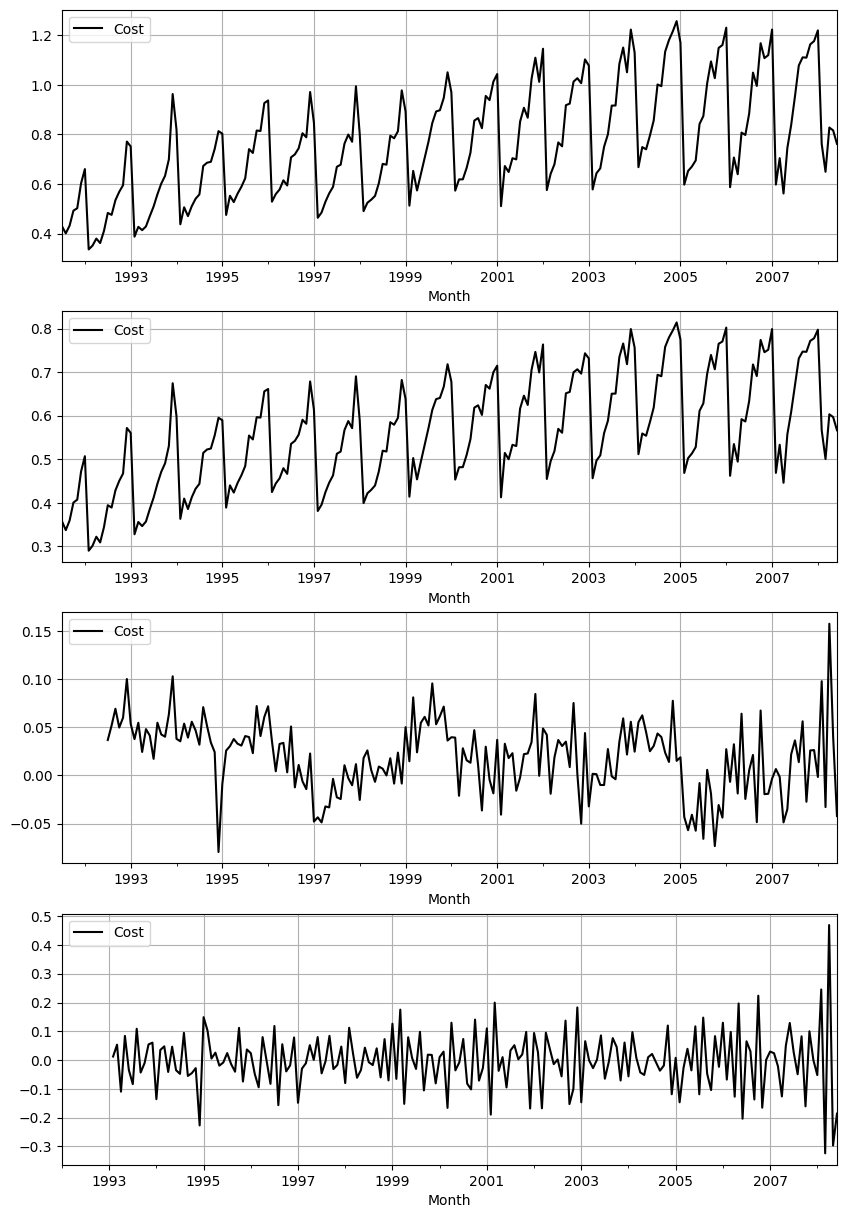

In [123]:
fig, ax = plt.subplots(4, 1, figsize=(10, 15))

df.plot(ax=ax[0], color="k")
np.log1p(df).plot(ax=ax[1], color="k")

np.log1p(df).diff(periods=12).plot(ax=ax[2], color="k")
np.log(df[df.index.year > 1991]).diff(12).diff().plot(ax=ax[3], color="k")

for axi in ax: axi.grid(2)

Apesar da série diferenciada ser estacionária ela parece muito mais ruído branco citado no capítulo 1, principalmente a série do `gafa_stock -> GOOG`, isso implica que "White Noise => Stationary", entretanto nem toda séries estacionárias são ruído branco como exemplo a série g) da primeira imagem.


Essencialmente White Noise pode ser modelado por um modelo Naive e a fórmula para prever um random walk é $y_t = y_{t-1} + e_t$ onde $e_t$ ~ $NID(0,~\sigma^{2})$


Podemos verificar se a série é estacionária ou não utilizando testes estatísticos, chamados de Unit Root Tests, são eles o ADF test e o KPSS test.

ADF Test.

- Ho: A série não é estacionária.
- Ha: A série é estacionária.


KPSS Test.

- Ho: A série é estacionária.
- Ha: A série não é estacionária.


Em testes estatísticos de hipóteses estamos interessados em rejeitar ou aceitar uma hipótese em favor de outra, inicia com a hipótese nula (ho), ou seja, sem efeito, contra a hipótese alternativa (ha) e usamos um valor chamado p valor para indicar se o teste deu sucesso em rejeitar algumas das duas hipóteses em favor de outra.

Em resumo:

- Se (pvalor < alpha), aceitamos a hipótese alternativa (ha), pois realmente teve um efeito no teste.
- Se (pvalor > alpha), aceitamos a hipótese nula (ho), pois o teste não identificou nada.

In [149]:
df = pd.read_csv("../data/gafa_stock.csv", index_col=[0])
df["Date"] = pd.to_datetime(df["Date"])

df = df[(df["Symbol"] == "GOOG") & (df["Date"].dt.year == 2018)].reset_index(drop=True)

# Alpha
alpha = 0.05

In [152]:
adfstat, pvalue, _, _, _, _ = adfuller(df["Close"].to_numpy())

if pvalue < alpha:
    print("Aceita a Hipótese Alternativa, a série é estacionária, pois o teste encontrou um efeito.")
else:
    print(f"Aceita a Hipótese Nula, a série não é estacionaria, com um pvalor: {pvalue:.04}")

Aceita a Hipótese Nula, a série não é estacionaria, com um pvalor: 0.2005


In [156]:
adfstat, pvalue, _, _, _, _ = adfuller(df["Close"].diff().dropna().to_numpy())

if pvalue < alpha:
    print("Aceita a Hipótese Alternativa, a série é estacionária, pois o teste encontrou um efeito.")
else:
    print(f"Aceita a Hipótese Nula, a série não é estacionaria, com um pvalor: {pvalue:.04}")

Aceita a Hipótese Alternativa, a série é estacionária, pois o teste encontrou um efeito.


In [158]:
df  = pd.read_csv("../data/PBS.csv", index_col=[0])
df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

df = df.loc[df.ATC2 == "H02", ["Month", "Cost"]].groupby("Month").sum() / 1e6

# Alpha
alpha = 0.05

In [163]:
adfstat, pvalue, _, _, _, _ = adfuller(df["Cost"].to_numpy())

if pvalue < alpha:
    print("Série é estacionaria")
else:
    print("Série não é estacionaria")

adfstat, pvalue, _, _, _, _ = adfuller(df["Cost"].diff().dropna().to_numpy())

if pvalue < alpha:
    print("Série é estacionaria")
else:
    print("Série não é estacionaria")

Série não é estacionaria
Série é estacionaria
